In [83]:
import datetime
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import sparkbeyond._api2.classes as sb
import numpy as np
import swifter
from scipy.optimize import curve_fit
import os
import logging
from data_preprocessing_util import *

In [84]:
raw_file_path = 'raw_data'
preprocessed_file_dest = f'preprocessed_data/nphr_{datetime.datetime.strftime(datetime.datetime.today().date(), "%m%d%Y")}'

if os.path.isdir(preprocessed_file_dest): pass
else: os.mkdir(preprocessed_file_dest)

### 1. Read Configuration File

In [85]:
with open('NPHR_config.json', 'rb') as b:
    config = json.load(b)

buckets = config['buckets']
buckets.append(np.inf)

### 2. Read PI Data

In [86]:
files_to_read = [file for file in os.listdir(raw_file_path) if file.endswith('csv')]

In [87]:
df2 = pd.read_csv(f'{raw_file_path}/analog_DEC2022.csv')

/usr/local/anaconda3/lib/python3.7/site-packages/IPython/core/interactiveshell.py:3063: DtypeWarning: Columns (315,317,327,329,333,339,435,437,447,449,453,459,1009,1010,1015,1292,1293,1294,1295,1296,1297,1306,1307,1308,1309,1319,1442,1516,1527,1529,1574,1576) have mixed types.Specify dtype option on import or set low_memory=False.
  interactivity=interactivity, compiler=compiler, result=result)


In [88]:
df2 = pd.read_csv(f'{raw_file_path}/analog_DEC2022.csv')
df2['datetime'] = pd.to_datetime(df2['datetime'])
df2 = df2.drop(['Date', 'Unnamed: 1614'], axis=1)
df2 = df2.sort_values(by='datetime').reset_index(drop=True)
df2 = df2.set_index('datetime')
df2 = df2.swifter.apply(pd.to_numeric,errors='coerce')

/usr/local/anaconda3/lib/python3.7/site-packages/swifter/swifter.py:88: UserWarning: This pandas object has duplicate indices, and swifter may not be able to improve performance. Consider resetting the indices with `df.reset_index(drop=True)`.
  "This pandas object has duplicate indices, "


Pandas Apply:   0%|          | 0/1612 [00:00<?, ?it/s]

In [89]:
files_to_read.remove('analog_DEC2022.csv')

In [142]:
df_list = []
for file in files_to_read:
    tmp = pd.read_csv(f'{raw_file_path}/{file}')
    tmp.rename({'Unnamed: 0':'datetime'}, axis=1, inplace=True)
    tmp['datetime'] = pd.to_datetime(tmp['datetime']).dt.tz_convert('Asia/Jakarta').dt.tz_localize(None)
    df_list.append(tmp)
    
df = pd.concat(df_list).reset_index(drop=True)
df = df.drop_duplicates(subset=['datetime'])
df['datetime'] = pd.to_datetime(df['datetime'])

df = df.sort_values(by='datetime').reset_index(drop=True)
df = df.set_index('datetime')
df = df.swifter.apply(pd.to_numeric,errors='coerce')


Pandas Apply:   0%|          | 0/1611 [00:00<?, ?it/s]

In [143]:
master_df = pd.concat([df, df2])

### 3. Train Data

In [147]:
net_heatrate_1 = master_df[['10NET_HEATRATE.CA','10CBP10CE010_ACTIVE_POWER.AV']].rename(columns={'10NET_HEATRATE.CA':'NET_HEATRATE.CA','10CBP10CE010_ACTIVE_POWER.AV':'load'})
net_heatrate_1['unit'] = 1
net_heatrate_1 = net_heatrate_1[(net_heatrate_1['load']>=5)&(net_heatrate_1['NET_HEATRATE.CA']>0)]

net_heatrate_2 = master_df[['20NET_HEATRATE.CA','20CBP10CE010_ACTIVE_POWER.AV']].rename(columns={'20NET_HEATRATE.CA':'NET_HEATRATE.CA','20CBP10CE010_ACTIVE_POWER.AV':'load'})
net_heatrate_2['unit'] = 2
net_heatrate_2 = net_heatrate_2[(net_heatrate_2['load']>=5)&(net_heatrate_2['NET_HEATRATE.CA']>0)]

net_heatrate_1 = net_heatrate_1.dropna(subset=['NET_HEATRATE.CA'])
net_heatrate_2 = net_heatrate_2.dropna(subset=['NET_HEATRATE.CA'])

#### Drop Unusual Operation Data

/usr/local/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:7: UserWarning: Matplotlib is currently using module://ipykernel.pylab.backend_inline, which is a non-GUI backend, so cannot show the figure.
  import sys


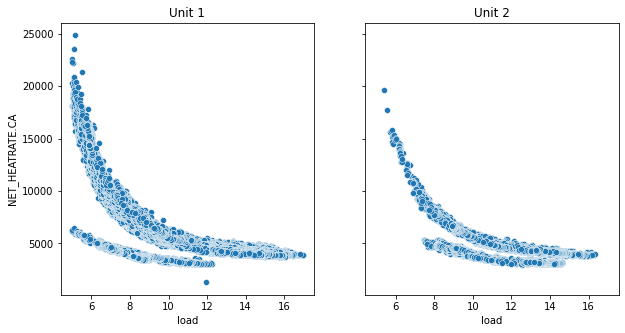

In [148]:
# visually identify unusual operating condition
fig, axes = plt.subplots(1,2, figsize=(10, 5), sharex=True, sharey=True)
sns.scatterplot(net_heatrate_1, x='load', y='NET_HEATRATE.CA', ax=axes[0])
sns.scatterplot(net_heatrate_2, x='load', y='NET_HEATRATE.CA', ax=axes[1])
axes[0].set_title('Unit 1')
axes[1].set_title('Unit 2')
fig.show()

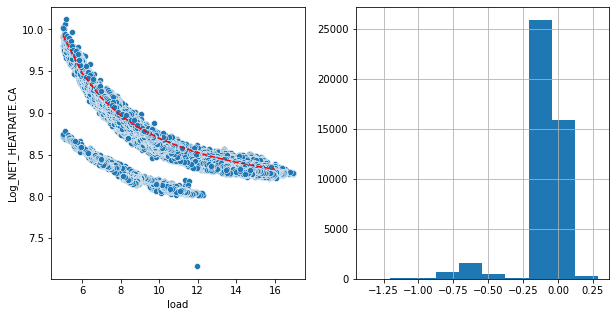

In [149]:
separator = separate_anomalies(net_heatrate_1)
separator.calc_normal_op_equation()
separator.visualize_distance()

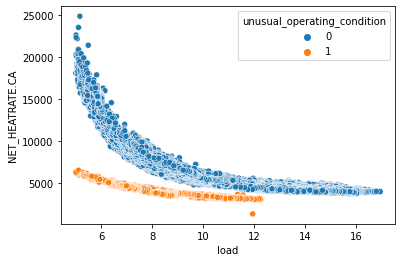

In [150]:
net_heatrate_1_clean = separator.separate()
separator.visualize_clusters()

In [151]:
net_heatrate_1_clean = net_heatrate_1_clean[net_heatrate_1_clean['unusual_operating_condition']==0]

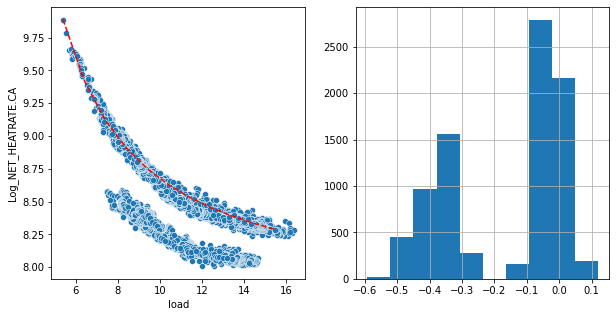

In [152]:
separator = separate_anomalies(net_heatrate_2)
separator.calc_normal_op_equation()
separator.visualize_distance()

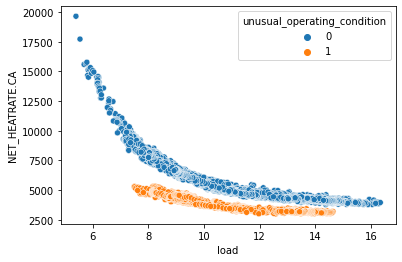

In [153]:
net_heatrate_2_clean = separator.separate()
separator.visualize_clusters()

In [154]:
net_heatrate_2_clean = net_heatrate_2_clean[net_heatrate_2_clean['unusual_operating_condition']==0]

/usr/local/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:6: UserWarning: Matplotlib is currently using module://ipykernel.pylab.backend_inline, which is a non-GUI backend, so cannot show the figure.
  


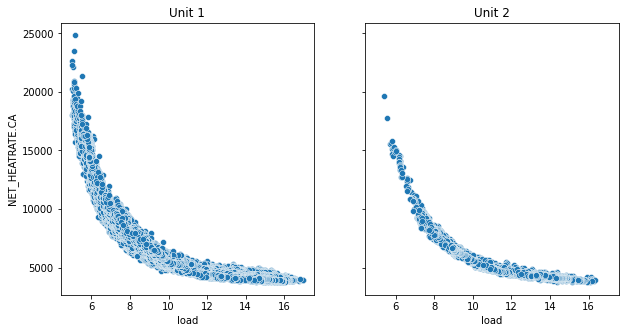

In [155]:
fig, axes = plt.subplots(1,2, figsize=(10, 5), sharex=True, sharey=True)
sns.scatterplot(net_heatrate_1_clean, x='load', y='NET_HEATRATE.CA', ax=axes[0])
sns.scatterplot(net_heatrate_2_clean, x='load', y='NET_HEATRATE.CA', ax=axes[1])
axes[0].set_title('Unit 1')
axes[1].set_title('Unit 2')
fig.show()

#### 3.2 Calculate Target Variable

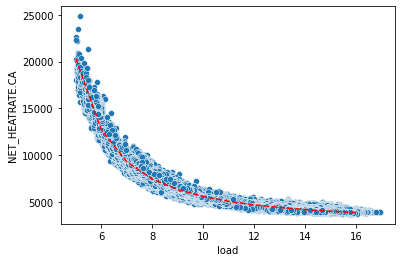

In [156]:
target_calc = target_calculator(net_heatrate_1_clean)
target_calc.calc_expected_nphr()
net_heatrate_1_target = target_calc.results_dataframe()
target_calc.visualize()

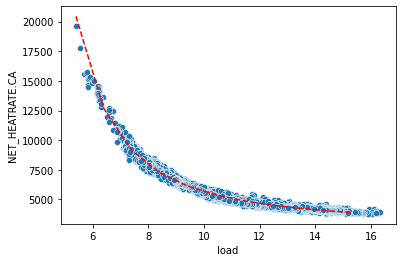

In [157]:
target_calc = target_calculator(net_heatrate_2_clean)
target_calc.calc_expected_nphr()
net_heatrate_2_target = target_calc.results_dataframe()
target_calc.visualize()

In [158]:
net_heatrate_1_target.to_csv(f'{preprocessed_file_dest}/train_unit1.csv')
net_heatrate_2_target.to_csv(f'{preprocessed_file_dest}/train_unit2.csv')

### 4. Controllable Context Data

In [159]:
'''
new_cont_tags = [
'PCS01_APP1.GAI10HNA41CT001',
'PCS01_APP1.GAI10HBK01CT021',
'PCS01_APP1.GAI10HBK01CT031',
'PCS01_APP1.GAI10HBK01CT042',
'PCS03_APP1.GAI10HBK01CP001',
'PCS03_APP1.GAI10HBK01CP002',
'PCS03_APP1.GAI10HBK01CP003'
]
'''
controllable_tags = config['controllables']
analog_tags = pd.read_csv('analog_tags.csv')

In [168]:
cont_boiler_unit1 = master_df[controllable_tags['BOILER UNIT 1']]
cont_boiler_unit2 = master_df[controllable_tags['BOILER UNIT 2']]

In [169]:
cont_boiler_unit1 = cont_boiler_unit1.rename(dict(zip(analog_tags['TAG NUMBER'], analog_tags['tag_desc_uom'])), axis=1)
cont_boiler_unit2 = cont_boiler_unit2.rename(dict(zip(analog_tags['TAG NUMBER'], analog_tags['tag_desc_uom'])), axis=1)

In [172]:
cont_boiler_unit1.to_csv(f'{preprocessed_file_dest}/cont_boiler_unit1.csv')
cont_boiler_unit2.to_csv(f'{preprocessed_file_dest}/cont_boiler_unit2.csv')